### ENVIRONMENTAL IMPACT DYNAMICS DUE TO COVID19 INDUCED CHANGES IN MOBILITY AND ECONOMY.

On the evening of March 24, the Indian government announced a national lockdown in its fight against COVID-19. The lockdown can be considered as an exogenous shock for the human mobility and economy. While there can be time fixed effects that can also contribute to the changes in the environment, any evidence of correlation between mobility/economic indicators and environment can provide possible explanations of causality, given the exogenous nature of lockdown.

#### Study Area:
For this project, the Union territory of Delhi is selected as the study area. Delhi is one of the most polluted cities in the world. This project aims to give some evidence if the lockdowns and associated reductions in mobility and economic activity helped Delhi breathe

Datasets are collected between the time span of 2017-01-01 to 2022-04-22. Given the large dataset considered, we can assume the distribution of each variable fits a Gaussian (bell curve) distribution. This will allow us to use Pearson correlation coefficient and Linear Regression to summarise relationship between variables.

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import geopandas as gpd

delhi_df = pd.read_csv('Data/master_timeseries.csv',parse_dates=[0]).set_index('date')
delhi_df

,ndti,ndvi,tmmx,Precipitation (mm/day),aod,NO2_column_number_density,avg_rad,retail_and_recreation_percent_change_from_baseline
date,,,,,,,,
2017-01-01,NaN,NaN,212.051731,0.0,1410.480210,NaN,25.657537,NaN
2017-01-02,NaN,NaN,NaN,0.0,1058.517596,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,0.0,820.840894,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,0.0,787.354347,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,0.0,895.224579,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-04-18,NaN,NaN,NaN,NaN,NaN,0.000181,NaN,-21.0
2022-04-19,-0.03041,0.110979,NaN,NaN,NaN,0.000143,NaN,-21.0
2022-04-20,NaN,NaN,NaN,NaN,NaN,0.000127,NaN,NaN


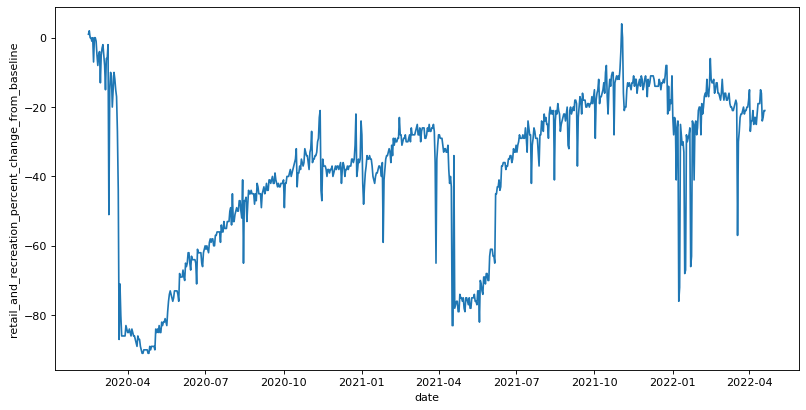

In [2]:
plt.figure(figsize=(12, 6), dpi=80)

sns.lineplot(x='date',y='retail_and_recreation_percent_change_from_baseline',data=delhi_df[['retail_and_recreation_percent_change_from_baseline']].reset_index())
plt.show()

#import plotly.graph_objects as go
#fig = go.Figure()
#df = delhi_df[['retail_and_recreation_percent_change_from_baseline']].dropna()
#fig.add_trace(
#    go.Scatter(x=list(df.index), y=list(df.retail_and_recreation_percent_change_from_baseline)))

#fig.update_layout(
 #   xaxis=dict(
  #      rangeslider=dict(
   #         visible=True
    #    ),
     #   type="date"
    #)
#)

#fig.show()

Delhi has seen two major reduction in mobility both in the April-May months of 2020 and 2021. The baseline of the Google mobility data is the median of every week-day of the 5 week period between January 3rd 2020-Februay 6th 2020. Other metrics to be analysed are also normalised based mean value of the same period for the sake of better comparison across variables. 

In [3]:
delhi_baseline_change_df = pd.read_csv('Data/delhi_baseline.csv', parse_dates=[0]).set_index('date')

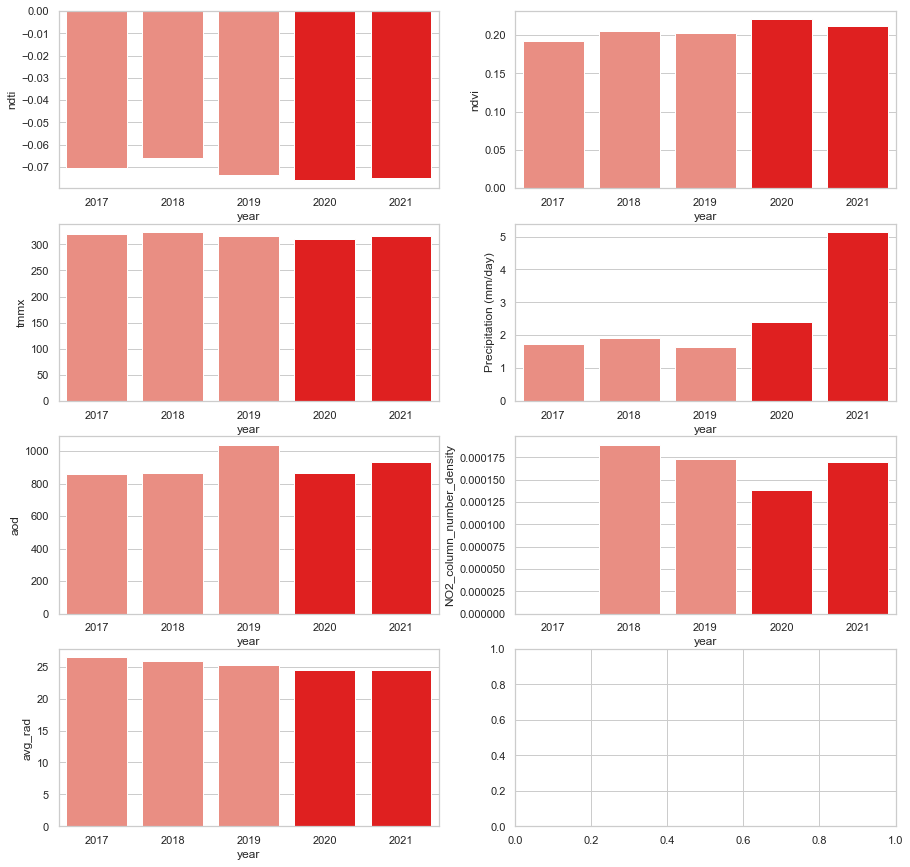

In [4]:
# Yearly means
delhi_df_yearlymeans = delhi_df['2017':'2021'].drop('retail_and_recreation_percent_change_from_baseline',axis=1).resample('Y').mean()
delhi_df_yearlymeans['year'] =delhi_df_yearlymeans.index.year 

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
axs = axs.flatten()
for counter, metric in enumerate(delhi_df_yearlymeans.drop('year',axis=1).columns):
    clrs = ['red' if ((x==2020)|(x==2021)) else 'salmon' for x in delhi_df_yearlymeans.year]
    sns.barplot(x="year", y=metric, data=delhi_df_yearlymeans,palette=clrs,ax=axs[counter])
plt.show()

Above plots do show that the COVID-19 impacted years showed a significant change when compared to other years. This is more evident with the NO2 pollution data, probably owing to the direct relationship between lockdowns and NO2 emissions. We can quantify this effect more numerically using the following regression. 

In [5]:
import statsmodels.formula.api as sm

delhi_baseline_change_df.columns = ['retail_baseline','ndti_baseline','ndvi_baseline','tmmx_baseline',
                                    'ppt_baseline','aod_baseline','no2_baseline','rad_baseline']
lockdown1 = []
lockdown2 = []
for metric in delhi_baseline_change_df.columns[1:]:    
    df = delhi_baseline_change_df[[metric]]['2017':'2021'].interpolate(method='linear').dropna()
    
    #df[metric] = df[metric].shift(periods=100)  #-- lag
    
    df['lockdown1'] = 0
    df.loc[(df.index >= '2020-03-24')&(df.index<= '2020-05-31'), 'lockdown1'] = 1
    
    df['lockdown2'] = 0
    df.loc[(df.index >= '2021-04-17')&(df.index <= '2021-06-07'), 'lockdown2'] = 1
    
    
    df['month'] = df.index.month.astype(str)
    df['year'] = df.index.year.astype(str)
    
    est = sm.ols(data=df.reset_index().dropna(),
            formula= '{} ~ lockdown1 +lockdown2 + C(month) +C(year)'.format(metric)).fit() # Put month and year FE; cluser se at the level of treatment
    
    results_summary = est.summary()
    results_as_html = results_summary.tables[1].as_html()
    reg_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
    lockdown1.append(reg_results.loc['lockdown1',:].to_list())
    lockdown2.append(reg_results.loc['lockdown2',:].to_list())
    

reg_after = pd.DataFrame(lockdown1)
reg_after2 = pd.DataFrame(lockdown2)

reg_after.columns = ['coef','std error','t','p','cel','ceu']
reg_after2.columns = ['coef','std error','t','p','cel','ceu']

reg_after.index= delhi_baseline_change_df.columns[1:]
reg_after2.index= delhi_baseline_change_df.columns[1:]

reg_after2.loc[reg_after2.p < 0.01, 'coef'] = reg_after2.coef.astype(str) + str('***')
reg_after2.loc[(reg_after2.p < 0.05)&(reg_after2.p >= 0.01), 'coef'] = reg_after2.coef.astype(str) + str('**')
reg_after2.loc[(reg_after2.p < 0.1)&(reg_after2.p >= 0.05), 'coef'] = reg_after2.coef.astype(str) + str('*')

reg_after.loc[reg_after.p < 0.01, 'coef'] = reg_after.coef.astype(str) + str('***')
reg_after.loc[(reg_after.p < 0.05)&(reg_after.p >= 0.01), 'coef'] = reg_after.coef.astype(str) + str('**')
reg_after.loc[(reg_after.p < 0.1)&(reg_after.p >= 0.05), 'coef'] = reg_after.coef.astype(str) + str('*')



cols = pd.MultiIndex.from_tuples([("Lockdown-1", "coef"), 
                                  ("Lockdown-1", "std error"), 
                                  ("Lockdown-1", "t"),
                                  ("Lockdown-1", "p"),
                                 ("Lockdown-1", "CI-L"),
                                 ("Lockdown-1", "CI-U"),
                                 ("Lockdown-2", "coef"), 
                                  ("Lockdown-2", "std error"), 
                                  ("Lockdown-2", "t"),
                                  ("Lockdown-2", "p"),
                                 ("Lockdown-2", "CI-L"),
                                 ("Lockdown-2", "CI-U")])


df = pd.DataFrame(pd.concat([reg_after,reg_after2],axis=1).values ,columns=cols,index=delhi_baseline_change_df.columns[1:])
df

Lockdown-1                                            \
                     coef std error      t      p     CI-L     CI-U   
ndti_baseline  -9.4977***     3.615 -2.627  0.009  -16.588   -2.407   
ndvi_baseline  10.3024***     2.791  3.692    0.0    4.829   15.775   
tmmx_baseline  -4.4467***     0.848 -5.245    0.0   -6.109   -2.784   
ppt_baseline       0.6175   166.235  0.004  0.997 -325.416  326.651   
aod_baseline      -5.2055    10.975 -0.474  0.635   -26.73   16.319   
no2_baseline   -13.8967**     6.654 -2.088  0.037  -26.951   -0.843   
rad_baseline    -1.866***     0.692 -2.698  0.007   -3.222    -0.51   

               Lockdown-2                                            
                     coef std error      t      p     CI-L     CI-U  
ndti_baseline      2.2966     3.964  0.579  0.562   -5.477    10.07  
ndvi_baseline    6.2361**     3.059  2.038  0.042    0.236   12.236  
tmmx_baseline  -6.1137***      0.93 -6.577    0.0   -7.937    -4.29  
ppt_baseline         59.6   182.271  0.327  0.744 -297.885  417.085  
aod_baseline       3.5828    12.033  0.298  0.766  -20.018   27.184  
no2_baseline    -13.9026*     7.153 -1.944  0.052  -27.935     0.13  
rad_baseline        1.009     0.758  1.331  0.183   -0.478    2.496

**NOTE:** The above effects are after considering time fixed effects of seasonality and trend. Hence, the coefficients would only correspond to the effect of lockdown on them.

During the first lockdown, Temperature reduced by 4%; NO2 pollution reduced by 17%; We also see a reduction of 2% in radiance and 11% increase in NDVI. The pattern remains similar during the second lockdown as well; but we see more NDTI during second wave.

We don't see significant results on aerosols. With reduction in mobility, it was expected that aerosols in air would reduce (lesser particulate matter).

Gaining inspiration from the above trends, we can now try to explore the relationship between the variables. The dependent variables are the environmental variables (pollution, temperature etc) and the independent variables are economic variables. 

In [6]:
from stargazer.stargazer import Stargazer
df = delhi_df[['avg_rad','retail_and_recreation_percent_change_from_baseline']]['2017':'2021'].interpolate(method='linear').dropna()
    
df['month'] = df.index.month.astype(str)
df['year'] = df.index.year.astype(str)
    
est = sm.ols(data=df.reset_index(),
            formula= 'avg_rad ~ retail_and_recreation_percent_change_from_baseline + C(month) +C(year)').fit()

stargazer = Stargazer([est])
stargazer

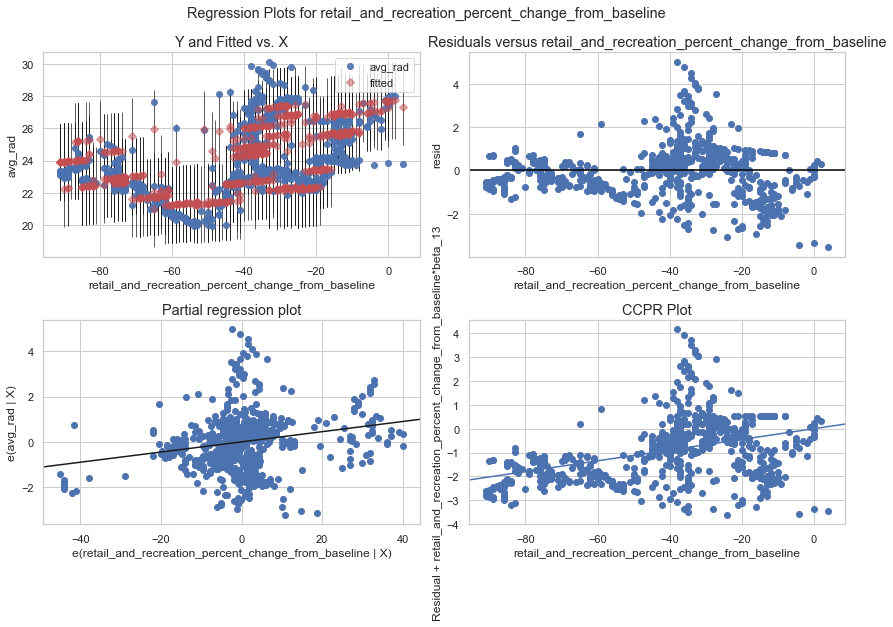

In [7]:
import statsmodels.api as sma
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sma.graphics.plot_regress_exog(est,'retail_and_recreation_percent_change_from_baseline',fig=fig)

A percent increase in mobility will cause 0.029 increase in night lights radiance. During lockdown, mobility fell upto the range of 80% on a few days. This might have caused significant reduction in night lights radiance as well. We'll use night lights variable as the independent variable to regress other environmental variables.

In [8]:
import numpy as np
from osgeo import gdal
ds = gdal.Open("Delhi_Nightlights_2019_apr.tif")
myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
myarray = myarray.astype('float')
night_2019 = (myarray.flatten())

ds = gdal.Open("Delhi_Nightlights_2020_apr.tif")
myarray = np.array(ds.GetRasterBand(1).ReadAsArray())
myarray = myarray.astype('float')
night_2020 = (myarray.flatten())

In [9]:
night_2019[night_2019<0.6] #No noise values

array([], dtype=float64)

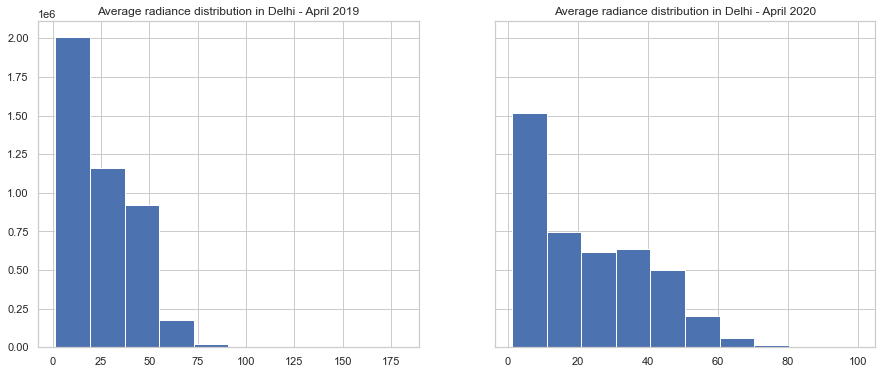

In [10]:
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,6),sharey=True)
axs = axs.flatten()
axs[0].hist(night_2019)
axs[0].set_title('Average radiance distribution in Delhi - April 2019')
axs[1].hist(night_2020)
axs[1].set_title('Average radiance distribution in Delhi - April 2020')

plt.show()

We can see that not only mean radiance has reduced in April 2020, but also the peak radiance value has also reduced.

### Regressions

In [11]:
dff = delhi_baseline_change_df[['no2_baseline','rad_baseline']].interpolate()['2017':'2021'].diff(365).merge(delhi_baseline_change_df[['retail_baseline']].interpolate(),on='date')
#dff.columns = ['tmmx','retail_baseline','rad_baseline']
#dff['ndvi_scaled10'] = dff['ndvi']*10  ##Scaling.
#dff['month'] = df.index.month.astype(str)
#dff['year'] = df.index.year.astype(str)
est = sm.ols(data=dff[['no2_baseline','retail_baseline']].dropna().reset_index(),
            formula= 'no2_baseline ~ retail_baseline').fit()
est2 = sm.ols(data=dff[['no2_baseline','rad_baseline']].dropna().reset_index(),
            formula= 'no2_baseline ~ rad_baseline').fit()

stargazer = Stargazer([est, est2])
stargazer

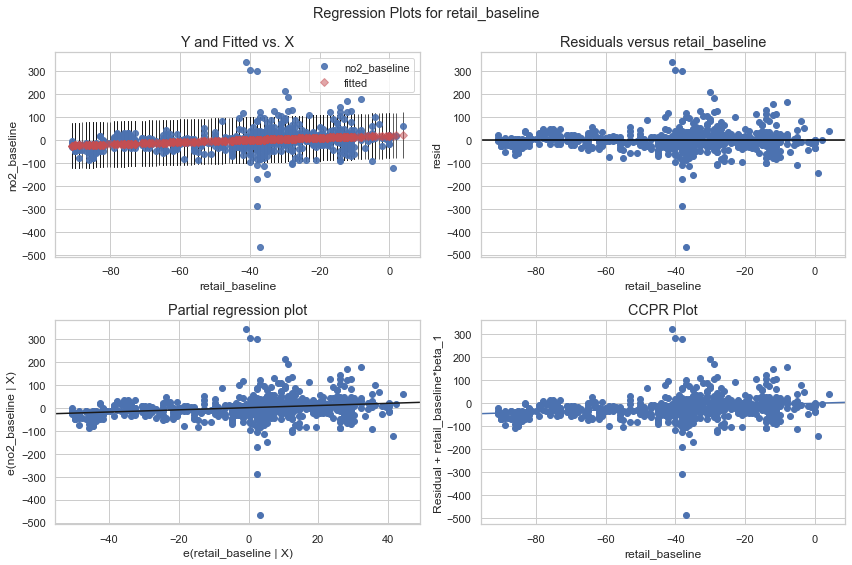

In [12]:
import statsmodels.api as sma
fig = plt.figure(figsize=(12,8))
fig = sma.graphics.plot_regress_exog(est,'retail_baseline',fig=fig)

In [13]:
dff = delhi_baseline_change_df[['tmmx_baseline','rad_baseline']].interpolate()['2017':'2021'].diff(365).merge(delhi_baseline_change_df[['retail_baseline']].interpolate(),on='date')
#dff.columns = ['tmmx','retail_baseline','rad_baseline']
#dff['ndvi_scaled10'] = dff['ndvi']*10  ##Scaling.
#dff['month'] = df.index.month.astype(str)
#dff['year'] = df.index.year.astype(str)
est = sm.ols(data=dff[['tmmx_baseline','retail_baseline']].dropna().reset_index(),
            formula= 'tmmx_baseline ~ retail_baseline').fit()
est2 = sm.ols(data=dff[['tmmx_baseline','rad_baseline']].dropna().reset_index(),
            formula= 'tmmx_baseline ~ rad_baseline').fit()

stargazer = Stargazer([est, est2])
stargazer

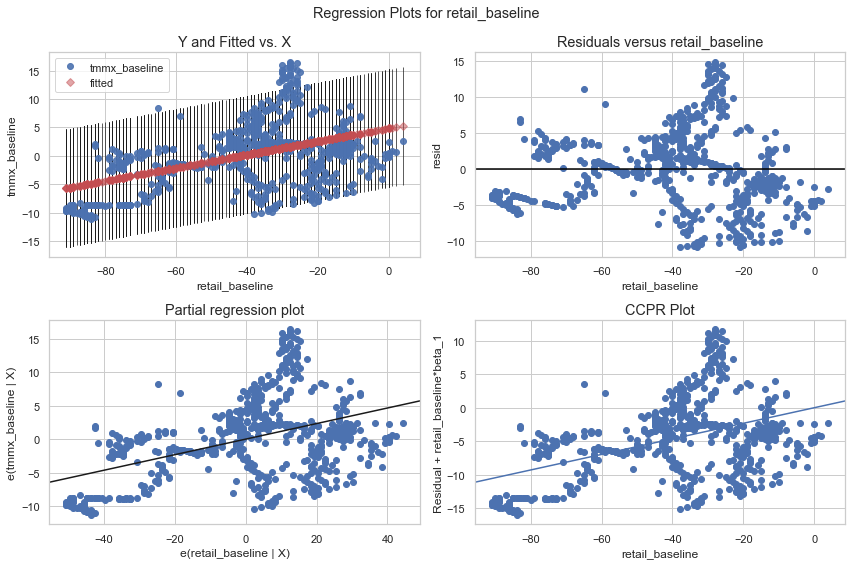

In [14]:
import statsmodels.api as sma
fig = plt.figure(figsize=(12,8))
fig = sma.graphics.plot_regress_exog(est,'retail_baseline',fig=fig)

In [18]:
dff = delhi_baseline_change_df[['ndvi_baseline','rad_baseline']].interpolate()['2017':'2021'].diff(365).merge(delhi_baseline_change_df[['retail_baseline']].interpolate(),on='date')
#dff.columns = ['tmmx','retail_baseline','rad_baseline']
#dff['ndvi_scaled10'] = dff['ndvi']*10  ##Scaling.
#dff['month'] = df.index.month.astype(str)
#dff['year'] = df.index.year.astype(str)
est = sm.ols(data=dff[['ndvi_baseline','retail_baseline']].dropna().reset_index(),
            formula= 'ndvi_baseline ~ retail_baseline').fit()
est2 = sm.ols(data=dff[['ndvi_baseline','rad_baseline']].dropna().reset_index(),
            formula= 'ndvi_baseline ~ rad_baseline').fit()

stargazer = Stargazer([est, est2])
stargazer


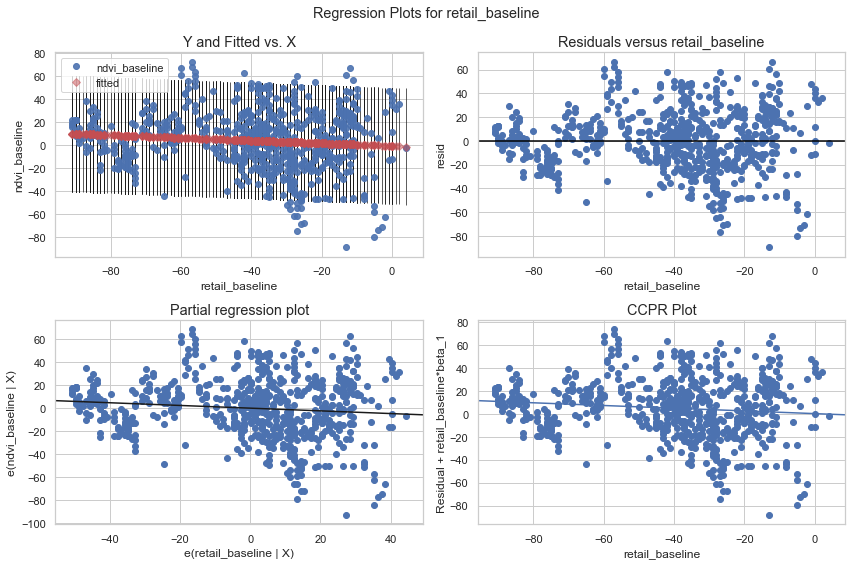

In [16]:
import statsmodels.api as sma
fig = plt.figure(figsize=(12,8))
fig = sma.graphics.plot_regress_exog(est,'retail_baseline',fig=fig)

In [23]:
dff = delhi_baseline_change_df[['ppt_baseline','rad_baseline']].interpolate()['2017':'2021'].diff(365).merge(delhi_baseline_change_df[['retail_baseline']].interpolate(),on='date')
dff['ppt_baseline_lag'] = dff[['ppt_baseline']].shift(periods=-64)

#dff['month'] = df.index.month.astype(str)
#dff['year'] = df.index.year.astype(str)
est = sm.ols(data=dff[['ppt_baseline_lag','retail_baseline']].dropna().reset_index(),
            formula= 'ppt_baseline_lag ~ retail_baseline').fit()
est2 = sm.ols(data=dff[['ppt_baseline_lag','rad_baseline']].dropna().reset_index(),
            formula= 'ppt_baseline_lag ~ rad_baseline').fit()

stargazer = Stargazer([est, est2])
stargazer

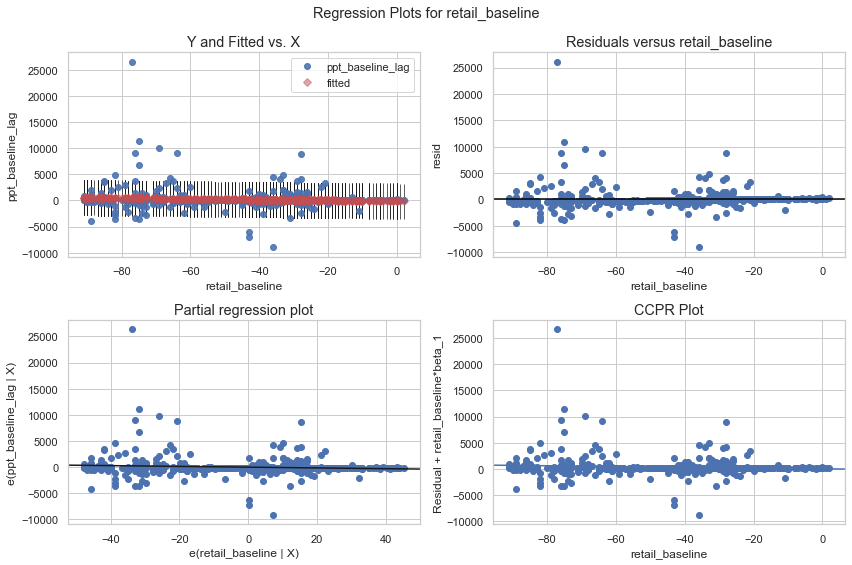

In [18]:
import statsmodels.api as sma
fig = plt.figure(figsize=(12,8))
fig = sma.graphics.plot_regress_exog(est,'retail_baseline',fig=fig)

In [22]:
dff = delhi_baseline_change_df[['ndti_baseline','rad_baseline']].interpolate()['2017':'2021'].diff(365).merge(delhi_baseline_change_df[['retail_baseline']].interpolate(),on='date')

#dff.columns = ['tmmx','retail_baseline','rad_baseline']
#dff['ndvi_scaled10'] = dff['ndvi']*10  ##Scaling.
#dff['month'] = df.index.month.astype(str)
#dff['year'] = df.index.year.astype(str)
est = sm.ols(data=dff[['ndti_baseline','retail_baseline']].dropna().reset_index(),
            formula= 'ndti_baseline ~ retail_baseline').fit()
est2 = sm.ols(data=dff[['ndti_baseline','rad_baseline']].dropna().reset_index(),
            formula= 'ndti_baseline ~ rad_baseline').fit()

stargazer = Stargazer([est, est2])
stargazer

In [21]:
dff = delhi_baseline_change_df[['aod_baseline','rad_baseline']].interpolate()['2017':'2021'].diff(365).merge(delhi_baseline_change_df[['retail_baseline']].interpolate(),on='date')
#dff.columns = ['tmmx','retail_baseline','rad_baseline']
#dff['ndvi_scaled10'] = dff['ndvi']*10  ##Scaling.
#dff['month'] = df.index.month.astype(str)
#dff['year'] = df.index.year.astype(str)
est = sm.ols(data=dff.reset_index(),
            formula= 'aod_baseline ~ retail_baseline').fit()
est2 = sm.ols(data=dff.reset_index(),
            formula= 'aod_baseline ~ rad_baseline').fit()

stargazer = Stargazer([est, est2])
stargazer

Improvements:
1. Non-Linearity is not tested.
2. electricity consumption.
3. Water quality through NDTI: https://www.tandfonline.com/doi/pdf/10.1080/19475705.2020.1782482


In [21]:
import geopandas as gpd

In [22]:
gpd.read_file('Delhi.geojson').to_crs('EPSG:3857').geometry.area[0]

1934890743.7721016